## Barotropic streamfunction
Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 40419:127.0.0.1:40419 vdi-n6.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:45498 Dashboard: http://127.0.0.1:40419/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average from 1998 onwards, aiming for the average of the streamfunction over the concurrent period of the simulation, following 0.1° spinup.

In [4]:
def get_gyre_psi(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cntrl_tx_trans = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',
                                        n=n_files,time_units=time_units, offset=offset)\
                                        .sel(time=slice(pd.datetime(1998,1,1),None)).mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts
    
    return gyre_psi

In [5]:
def global_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-160,160.01,2)
    clev2 = np.arange(-140,140.01,10)
    
    map = Basemap(projection='mbtfpq',lon_0 = -100,resolution='l')
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-60.,61.,30.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(-180.,181.,90.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [6]:
def agulhas_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)
    
    map = Basemap(llcrnrlon=10,llcrnrlat=-50,urcrnrlon=79.9,urcrnrlat=-20,
             resolution='l', projection='cyl', lat_0 = 35, lon_0 = -35)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-50.,-20.,10.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(0.,81.,20.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [7]:
def kuroshio_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-240,urcrnrlon=-120,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [8]:
def gulfstream_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-95,urcrnrlon=-5,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [9]:
def eac_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-30,30.01,1)
    clev2 = np.arange(-25,25.01,5)
    
    map = Basemap(projection='cyl',llcrnrlat=-55,urcrnrlat=-20,\
            llcrnrlon=-220,urcrnrlon=-140,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

## Plot gyre transport, with DP transport subtracted

This is the plot designed for the model evaluation paper.

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139704545801984 and this is thread id 139702169540352.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f0f1beaef10>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139704545801984 and this is thread id 139702169540352.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f0f1b8dcab0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3635: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3635: RuntimeWarning: invalid value encountered in less_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3648: RuntimeWarning: invalid value encountered in greater
  xx = ma.masked_where(x > 1.e20, x)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139704545801984 and this is thread id 139702169540352.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f0f0d12ff10>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3635: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3635: RuntimeWarning: invalid value encountered in less_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3648: RuntimeWarning: invalid value encountered in greater
  xx = ma.masked_where(x > 1.e20, x)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139704545801984 and this is thread id 139702169540352.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f0f0d18c3b0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139704545801984 and this is thread id 139702169540352.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f0f0d12f490>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3635: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3635: RuntimeWarning: invalid value encountered in less_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3648: RuntimeWarning: invalid value encountered in greater
  xx = ma.masked_where(x > 1.e20, x)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07

CPU times: user 19min 7s, sys: 3min 29s, total: 22min 37s
Wall time: 50min 43s


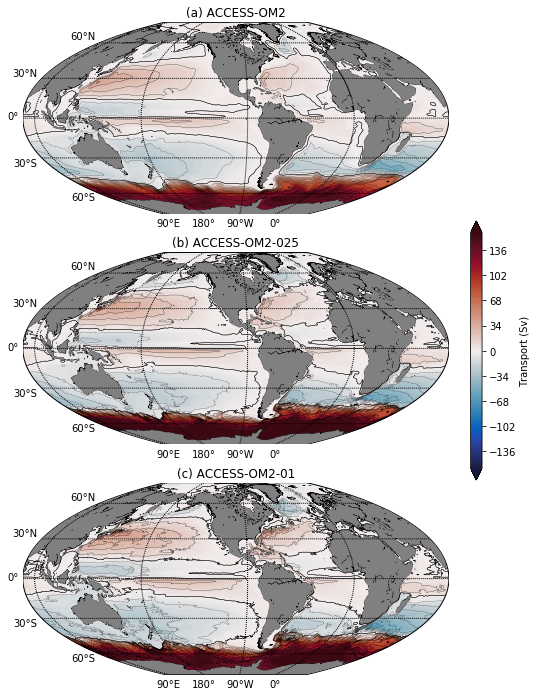

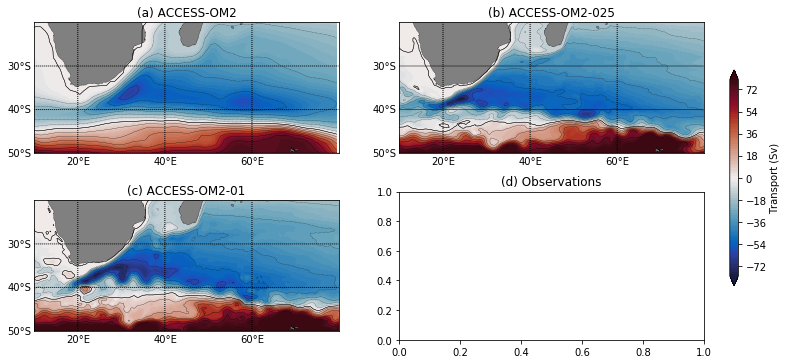

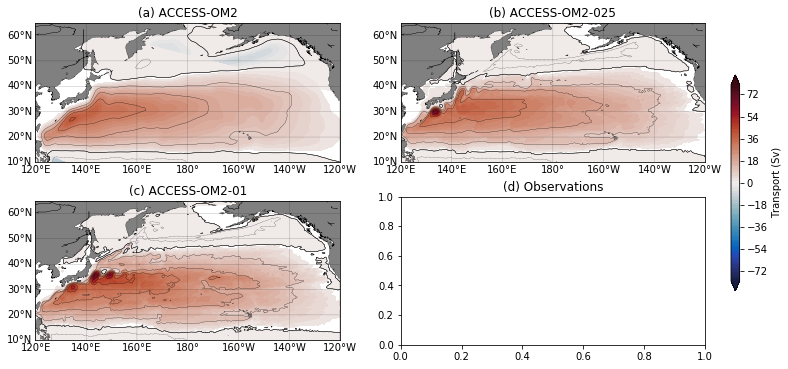

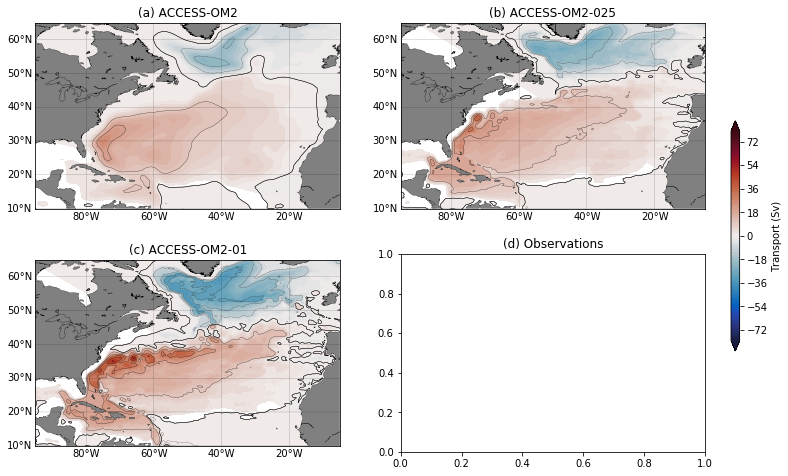

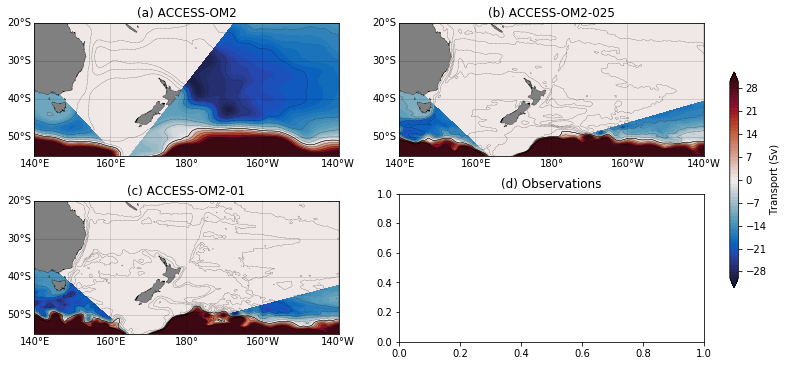

In [10]:
%%time
plt.figure(1,figsize(8,12))
plt.figure(2,figsize(12,6))
plt.figure(3,figsize(12,6))
plt.figure(4,figsize(12,8))
plt.figure(5,figsize(12,6))

plot_labels=['(a) ','(b) ','(c) ']

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    geolon_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolon_t',n=1).mean('time')
    geolat_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolat_t',n=1).mean('time')
    
    label=plot_labels[i]
    
    plt.figure(1)
    plt.subplot(3,1,i+1)
    p1 =global_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(2)
    plt.subplot(2,2,i+1)
    p2 =agulhas_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(3)
    plt.subplot(2,2,i+1)
    p3 = kuroshio_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(4)
    plt.subplot(2,2,i+1)
    p4 = gulfstream_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(5)
    plt.subplot(2,2,i+1)
    p5 = eac_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
plt.figure(1)
ax3 = plt.axes([0.92,0.35,0.02,0.3])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('global_barotropic_streamfunctions')

plt.figure(2)
subplot(224)
plt.title('(d) Observations')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p2,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('agulhas_barotropic_streamfunctions')

plt.figure(3)
subplot(224)
plt.title('(d) Observations')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p3,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('kuroshio_barotropic_streamfunctions')

plt.figure(4)
subplot(224)
plt.title('(d) Observations')
ax3 = plt.axes([0.93,0.3,0.01,0.4])
cb = plt.colorbar(p4,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('gulfstream_barotropic_streamfunctions')

plt.figure(5)
subplot(224)
plt.title('(d) Observations')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p5,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('eac_barotropic_streamfunctions')

# Below here, plots are old, not maintained.

------------

## Plot ACC transport

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


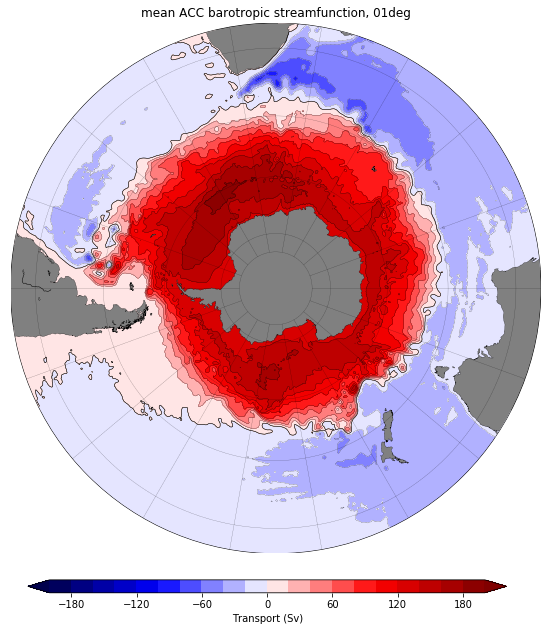

In [13]:
levels = np.linspace(-200,200,21)

plt.figure(figsize(9.5,12))

plt.subplot(1,1,1)
# map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map = Basemap(projection ='spstere',boundinglat=-25,lon_0=-150,resolution='l',round=True)
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-90.,91.,15.),linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[0,0,0,0],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=levels, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(-200,200,20)
# print clev3
map.contour(X,Y,gyre_psi,levels=clev3,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title('mean ACC barotropic streamfunction, ' + ekey)

ax3 = plt.axes([0.15,0.15,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')

savefigure('ACC_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 9:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f9.jpeg)

## Plot Kuroshio transport, with DP transport subtracted

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3634: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analy

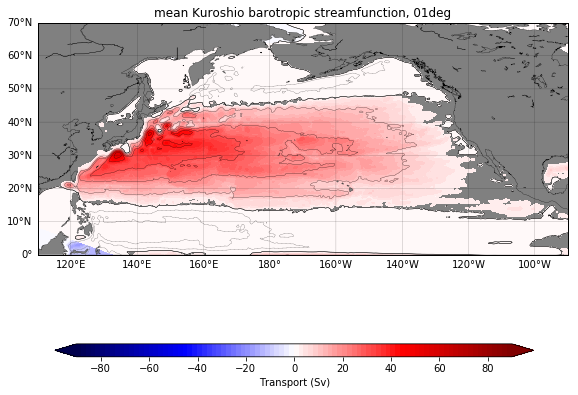

In [7]:
# gyre_psi = -cntrl_psi+cntrl_dp_ts

plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
clev = np.arange(-90,90.1,2)
clev2 = np.arange(-90,90.1,10)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=70,\
            llcrnrlon=-250,urcrnrlon=-90,resolution='l') # WARNING: includes tripole region north of 65N
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.PiYG, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title('mean Kuroshio barotropic streamfunction, ' + ekey)

ax3 = plt.axes([0.15,0.25,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')
savefigure('Kuroshio_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 7:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f7.jpeg)

## Plot Gulf Stream transport, with DP transport subtracted

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3634: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3634: RuntimeWarning: invalid value encountered in less_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3647: RuntimeWarning: invalid value encountered in greater
  xx = ma.masked_where(x > 1.e20, x)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py

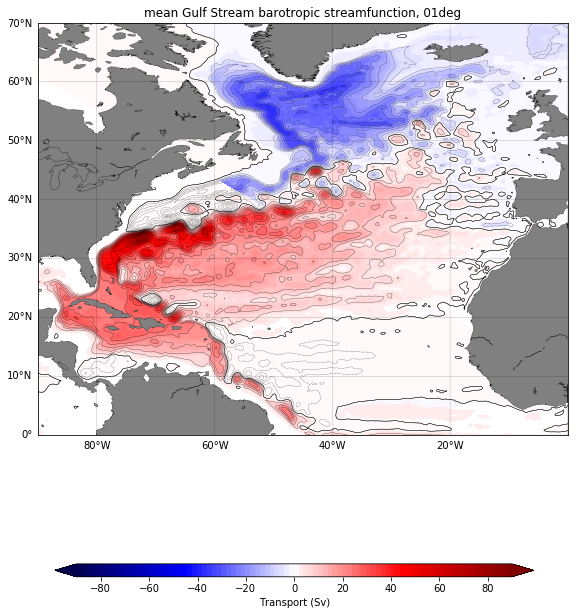

In [11]:
# gyre_psi = -cntrl_psi+cntrl_dp_ts

plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
clev = np.arange(-90,90.1,2)
clev2 = np.arange(-90,90.1,5)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=70,\
            llcrnrlon=-90,urcrnrlon=0,resolution='l') # WARNING: includes tripole region north of 65N
#map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
# plt.title('Barotropic streamfunction')
plt.title('mean Gulf Stream barotropic streamfunction, ' + ekey)

ax3 = plt.axes([0.15,0.1,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')
savefigure('GulfStream_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 3:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f3.jpeg)